# Four-momentum tests

In these examples, we get out the information from an ntuple needed to reconstruct the momentum of jets and LLPs.

### Ntuple column names
First, just print out all the TBranch names in the ROOT file, so we can see what we have to work with.

In [1]:
import uproot
input_file = uproot.open('/LLPData/Outputs/CalRatio_ntuples2016dataAnalysis_paperVersion/signal_HSS_LLP_mH1000_mS150_lt9m_ntuples2016dataAnalysis_addingMETinfo.root')
base_awkward_array = input_file[input_file.keys()[0]].lazyarrays(namedecode='utf-8')
for key in base_awkward_array:
    print(key)

eventNumber
eventCount
runNumber
lumiBlock
backgroundFlags
eventWeight
pdfEventWeights
pileupEventWeight
xSecEventWeight
actualIntPerCrossing
averageIntPerCrossing
event_NCleanJets
event_NJets
event_HT
event_MHToHT
event_HTMiss
event_HTMiss_x
event_HTMiss_y
event_Meff
event_sumMinDR
METCST_met
METCST_phi
METCST_mpx
METCST_mpy
METTST_met
METTST_phi
METTST_mpx
METTST_mpy
event_tauRoI_maxET
event_passL1TAU60
event_passL1LLPNOMATCH
event_passEmulationL1LLPNOMATCH
event_passL1LLPRO
event_passCalRatio_cleanLLP_TAU60
event_passCalRatio_cleanLLP_TAU60_noiso
event_passCalRatio_cleanLLP_LLPNOMATCH
event_passCalRatio_cleanLLP_LLPNOMATCH_noiso
event_passEmulationCalRatio_cleanLLP_LLPNOMATCH_noiso
event_passJ320_bperf_split
dPhiLeadBDTsignalWeight_cleanJet
dRLeadBDTsignalWeight_cleanJet
dPhiLeadBDTmultijetsWeight_cleanJet
dRLeadBDTmultijetsWeight_cleanJet
dPhiLeadBDTbibWeight_cleanJet
dRLeadBDTbibWeight_cleanJet
event_BDTtau60
event_BDTllpnm
BDT3weights_signal_cleanJet_index
BDT3weights_multijets_c

### Setup
Add the right path, import the right library, and set up the event stream.

In [2]:
import sys
sys.path.append('..')
from clientlib.DataSets import ArrayDataSet

In [3]:
real_awkward_dataset = ArrayDataSet('/LLPData/Outputs/CalRatio_ntuples2016dataAnalysis_paperVersion/signal_HSS_LLP_mH1000_mS150_lt9m_ntuples2016dataAnalysis_addingMETinfo.root')
real_awkward_array_stream = real_awkward_dataset.AsAwkwardArray()

## Query
Here we actually set the query that will run on the ntuple. This will select the energy, pT, eta, and phi of every jet and every LLP.

In [4]:
real_awkward_query = real_awkward_array_stream.Select('lambda e: ((e.CalibJet_E, e.CalibJet_pT, e.CalibJet_eta, e.CalibJet_phi), (e.LLP_E, e.LLP_pT, e.LLP_eta, e.LLP_phi))')

Now run the query, which should take a few seconds.

In [5]:
%time output_array = real_awkward_query.value()

CPU times: user 57.7 ms, sys: 32 ms, total: 89.8 ms
Wall time: 14.1 s


## Custom Python implementation of four-vectors
We need to do operations on four-vectors, like adding two together and getting invariant masses. I've written my own version of the necessary objects and operators here. This may be reinventing the wheel a bit, but there are still some issues with using `uproot-methods`'s implementation, so this will have to do for now.

In [6]:
from numpy import arcsinh, arctan2, hypot, isinf, cosh, cos, sin, sinh, sqrt
from math import pi

def get_eta_from_pT_and_pz(pT, pz):
    #if pT != 0:
        return arcsinh(pz / pT)
    #elif pz == 0:
    #    return 0
    #else:
    #    return float('infinity') * pz

class ThreeMomentum:
    def __init__(self, px, py, pz):
        self._px = px
        self._py = py
        self._pz = pz
        
    def __str__(self):
        return ('(' + str(self._px) + ', '
                    + str(self._py) + ', '
                    + str(self._pz) + ')')
    
    def px(self):
        return self._px
    
    def py(self):
        return self._py
    
    def pz(self):
        return self._pz
    
    def pT(self):
        return hypot(self._px, self._py)

    def eta(self):
        return get_eta_from_pT_and_pz(self.pT(), self._pz)
    
    def phi(self):
        return arctan2(self._py, self._px)
        
    def __add__(self, other):
        return ThreeMomentum(self._px + other._px, self._py + other._py, self._pz + other._pz)

def get_smallest_radian_value(angle):
    greater_than_pi = angle > pi
    while greater_than_pi.flatten().sum() if hasattr(greater_than_pi, "flatten") else greater_than_pi:
        greater_than_pi = greater_than_pi * -2 * pi
        angle = angle + greater_than_pi
        greater_than_pi = angle > pi
    less_than_negative_pi = angle < -pi
    while less_than_negative_pi.flatten().sum() if hasattr(less_than_negative_pi, "flatten") else less_than_negative_pi:
        less_than_negative_pi = less_than_negative_pi * 2 * pi
        angle = angle + less_than_negative_pi
        less_than_negative_pi = angle < -pi
    #while angle > pi:
    #    angle -= 2 * pi
    #while angle < -pi:
    #     angle += 2 * pi
    return angle

class FourMomentum:
    def __init__(self, E, pT, eta, phi):
        #if isinf(E) or E < pT or pT < 0:
        #    raise ValueError()
        #if E == 0:
        #    if pT != 0:
        #        raise ValueError()
        #    self._E = E
        #    self._pT = pT
        #    self._eta = float('nan')
        #    self._phi = float('nan')
        #elif pT == 0:
        #    if not isinf(eta):
        #        raise ValueError()
        #    self._E = E
        #    self._pT = pT
        #    self._eta = eta
        #    self._phi = float('nan')
        #else:
        #    if isinf(eta) or isinf(phi):
        #        raise ValueError()
        #    if (pT * cosh(eta)) / E > 1.001:
        #        raise ValueError()
            self._E = E
            self._pT = pT
            self._eta = eta
            self._phi = get_smallest_radian_value(phi)
            
    @classmethod
    def from_E_and_p3(cls, E, p3):
        return cls(E, p3.pT(), p3.eta(), p3.phi())
            
    def __str__(self):
        return (  'E = '   + str(self._E)   + ', '
                + 'pT = '  + str(self._pT)  + ', '
                + 'eta = ' + str(self._eta) + ', '
                + 'phi = ' + str(self._phi))

    def __repr__(self):
        return (self.__class__.__name__ + '('
                + str(self._E) + ', '
                + str(self._pT) + ', '
                + str(self._eta) + ', '
                + str(self._phi) + ')')
    
    def E(self):
        return self._E
    
    def pT(self):
        return self._pT
    
    def eta(self):
        return self._eta
    
    def phi(self):
        return self._phi
    
    def px(self):
        #if self._pT == 0:
        #    return 0
        #else:
            return self.pT() * cos(self.phi())
    
    def py(self):
        #if self._pT == 0:
        #    return 0
        #else:
            return self.pT() * sin(self.phi())
    
    def pz(self):
        #if isinf(self._eta):
        #    raise NotImplementedError('Unable to calculate pz if pT = 0')
        #else:
            return self.pT() * sinh(self.eta())
        
    def eta(self):
        return self._eta
    
    def phi(self):
        return self._phi

    def p3(self):
        return ThreeMomentum(self.px(), self.py(), self.pz())
    
    def __add__(self, other):
        new_E = self._E + other._E
        new_p3 = self.p3() + other.p3()
        return self.from_E_and_p3(new_E, new_p3)
        
    def p3_squared(self):
        return self.px() ** 2 + self.py() ** 2 + self.pz() ** 2
        
    def p3_magnitude(self):
        return sqrt(self.p3_squared())
    
    def m(self):
        return sqrt(self._E ** 2 - self.p3_squared())
    
    def __getitem__(self, key):
        return __class__(self.E()[key], self.pT()[key], self.eta()[key], self.phi()[key])
    
    def __len__(self):
        return len(self.E())
    
    def counts(self):
        return self.E().counts()
    
    def argcross(self, other):
        return self.E().argcross(other.E())
    
    def flatten(self):
        return __class__(self.E().flatten(), self.pT().flatten(), self.eta().flatten(), self.phi().flatten())
    
    #def __getattr__(self, name):
    #    def pass_through(inner_self=self):
    #        getattr(inner_self._E, name)()
    #        getattr(inner_self._pT, name)()
    #        getattr(inner_self._eta, name)()
    #        getattr(inner_self._phi, name)()
    #    return pass_through
            
       # return (lambda inner_self:
       #             getattr(inner_self._E, name)()
       #             getattr(inner_self._pT, name)()
       #             getattr(inner_self._eta, name)()
       #             getattr(inner_self._phi, name)())
        
def deltaEta(v1, v2):
    return v2.eta() - v1.eta()

def deltaPhi(v1, v2):
    return get_smallest_radian_value(v2.phi() - v1.phi())

def deltaR(v1, v2):
    return hypot(deltaEta(v1, v2), deltaPhi(v1, v2))

## Construct four-vectors for jets and LLPs
Next, just pick out the right columns and make the FourMomentum objects. The above implementation is intentionally agnostic to whether the inputs are scalars or arrays of arbitrary dimensions. As long as the inputs match in shape, you'll get all the four-vectors out in a form that matches the inputs. I make one array for jets and one array for LLPs.

In [7]:
jet_E = output_array[0][0]
jet_pT = output_array[0][1]
jet_eta = output_array[0][2]
jet_phi = output_array[0][3]
jet_p4 = FourMomentum(jet_E, jet_pT, jet_eta, jet_phi)

In [8]:
LLP_E = output_array[1][0]
LLP_pT = output_array[1][1]
LLP_eta = output_array[1][2]
LLP_phi = output_array[1][3]
LLP_p4 = FourMomentum(LLP_E, LLP_pT, LLP_eta, LLP_phi)

## Plots
Use the FourMomentum arrays to plot the jet and LLP parameters.

In [9]:
import matplotlib.pyplot as plt

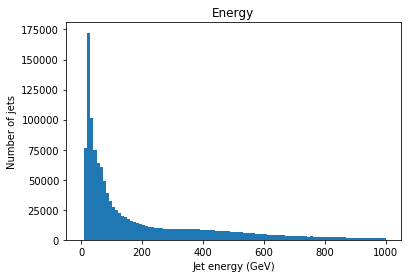

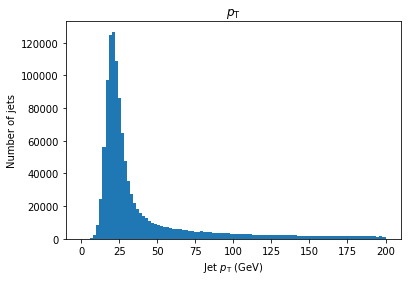

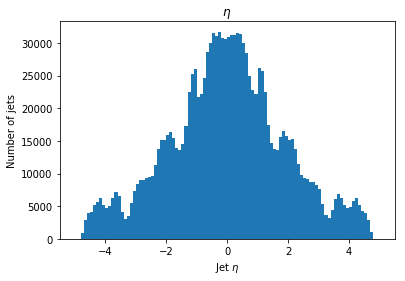

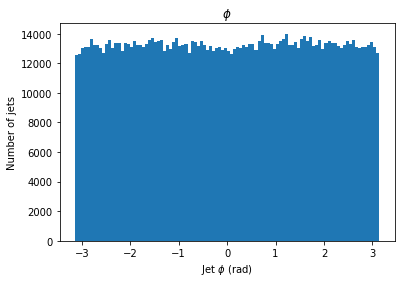

/home/mproffit/anaconda3/lib/python3.7/site-packages/awkward/array/jagged.py:993: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/mproffit/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/mproffit/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


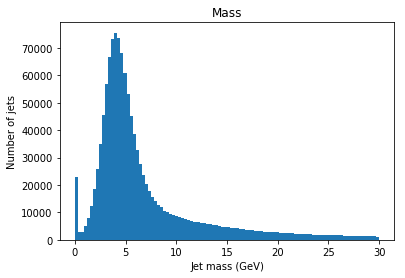

In [10]:
plt.hist(jet_p4.E().flatten(), 100, (0, 1000))
plt.title('Energy')
plt.xlabel('Jet energy (GeV)')
plt.ylabel('Number of jets')
plt.show()

plt.hist(jet_p4.pT().flatten(), 100, (0, 200))
plt.title('$p_\\mathrm{T}$')
plt.xlabel('Jet $p_\\mathrm{T}$ (GeV)')
plt.ylabel('Number of jets')
plt.show()

plt.hist(jet_p4.eta().flatten(), 100, (-5, 5))
plt.title('$\\eta$')
plt.xlabel('Jet $\\eta$')
plt.ylabel('Number of jets')
plt.show()

plt.hist(jet_p4.phi().flatten(), 100, (-pi, pi))
plt.title('$\\phi$')
plt.xlabel('Jet $\\phi$ (rad)')
plt.ylabel('Number of jets')
plt.show()

plt.hist(jet_p4.m().flatten(), 100, (0, 30))
plt.title('Mass')
plt.xlabel('Jet mass (GeV)')
plt.ylabel('Number of jets')
plt.show()

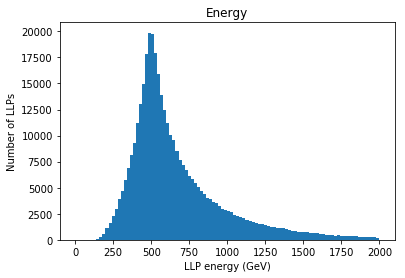

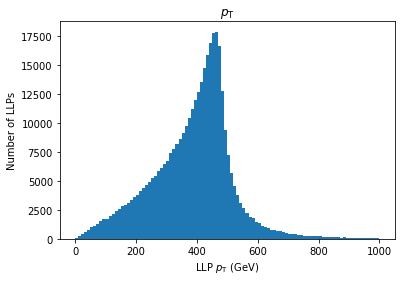

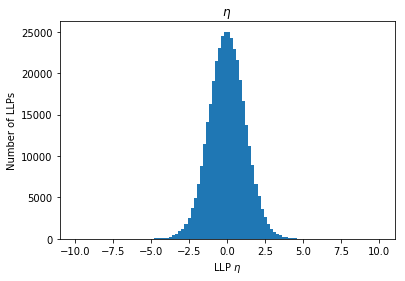

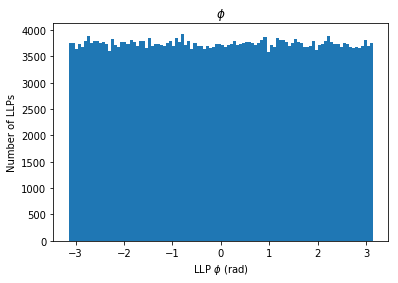

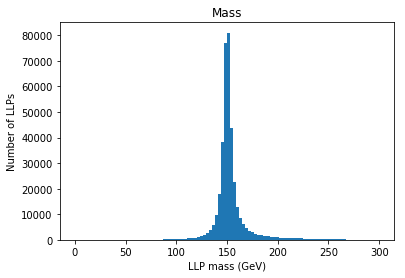

In [11]:
plt.hist(LLP_p4.E().flatten() / 1000, 100, (0,2000))
plt.title('Energy')
plt.xlabel('LLP energy (GeV)')
plt.ylabel('Number of LLPs')
plt.show()

plt.hist(LLP_p4.pT().flatten() / 1000, 100, (0,1000))
plt.title('$p_\\mathrm{T}$')
plt.xlabel('LLP $p_\\mathrm{T}$ (GeV)')
plt.ylabel('Number of LLPs')
plt.show()

plt.hist(LLP_p4.eta().flatten(), 100, (-10,10))
plt.title('$\\eta$')
plt.xlabel('LLP $\\eta$')
plt.ylabel('Number of LLPs')
plt.show()

plt.hist(LLP_p4.phi().flatten(), 100, (-pi,pi))
plt.title('$\\phi$')
plt.xlabel('LLP $\\phi$ (rad)')
plt.ylabel('Number of LLPs')
plt.show()

plt.hist(LLP_p4.m().flatten() / 1000, 100, (0,300))
plt.title('Mass')
plt.xlabel('LLP mass (GeV)')
plt.ylabel('Number of LLPs')
plt.show()

## Four-vector sums
We can verify the four-vector addition by summing the two LLPs in each event and ploting the resulting kinematics. This should correspond to the Φ scalar mediator with a mass of 125 GeV.

In [12]:
LLP_p4_sums = LLP_p4[:,0] + LLP_p4[:,1]

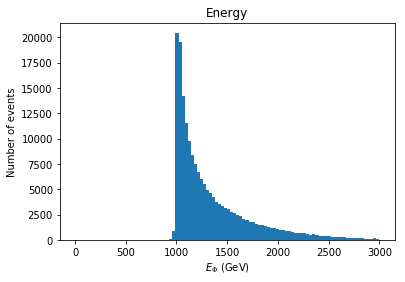

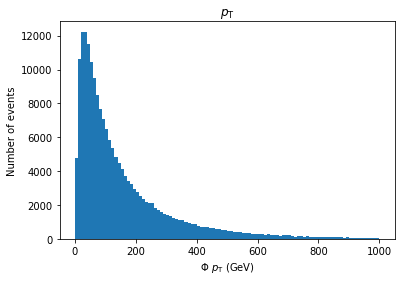

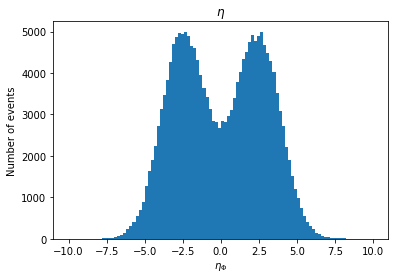

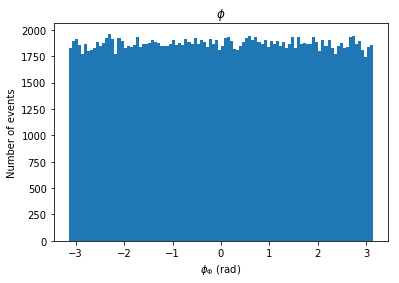

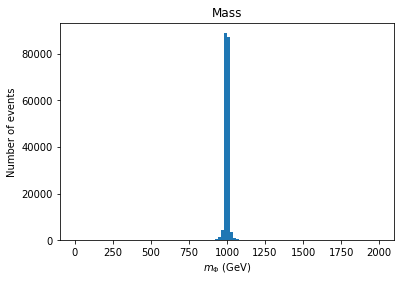

In [13]:
plt.hist(LLP_p4_sums.E() / 1000, 100, (0,3000))
plt.title('Energy')
plt.xlabel('$E_\\Phi$ (GeV)')
plt.ylabel('Number of events')
plt.show()

plt.hist(LLP_p4_sums.pT() / 1000, 100, (0,1000))
plt.title('$p_\\mathrm{T}$')
plt.xlabel('$\\Phi$ $p_\\mathrm{T}$ (GeV)')
plt.ylabel('Number of events')
plt.show()

plt.hist(LLP_p4_sums.eta(), 100, (-10,10))
plt.title('$\eta$')
plt.xlabel('$\\eta_\\Phi$')
plt.ylabel('Number of events')
plt.show()

plt.hist(LLP_p4_sums.phi(), 100, (-pi,pi))
plt.title('$\\phi$')
plt.xlabel('$\\phi_\\Phi$ (rad)')
plt.ylabel('Number of events')
plt.show()

plt.hist(LLP_p4_sums.m() / 1000, 100, (0,2000))
plt.title('Mass')
plt.xlabel('$m_\\Phi$ (GeV)')
plt.ylabel('Number of events')
plt.show()

# Jet-LLP matching
In order to do anything in the CalRatio analysis, I need to be able to match jets and LLPs so I know which are CalRatio jets.

## Jet-LLP pairs
The first step is to just get all possible pairs of jets and LLPs in each event. Thanks to `awkward`'s `argcross()` and the `unzip()` method I've added to it, this is very simple:

In [14]:
import awkward
pair_jet_indices, pair_llp_indices = jet_p4.argcross(LLP_p4).unzip()
print('There are', len(pair_jet_indices.flatten()), 'unique pairs of jets and LLPs across all', len(jet_p4), 'events.')

There are 2649674 unique pairs of jets and LLPs across all 187000 events.


The pairings are represented as the index of each jet and LLP within each event.

In [15]:
print('Jet indices:', pair_jet_indices)
print('LLP indices:', pair_llp_indices)

Jet indices: [[0 0 1 ... 7 8 8] [0 0 1 ... 3 4 4] [0 0 1 ... 7 8 8] ... [0 0 1 1] [0 0 1 ... 4 5 5] [0 0 1 ... 5 6 6]]
LLP indices: [[0 1 0 ... 1 0 1] [0 1 0 ... 1 0 1] [0 1 0 ... 1 0 1] ... [0 1 0 1] [0 1 0 ... 1 0 1] [0 1 0 ... 1 0 1]]


Each vertical column above represents one pair. There are two pairs for each jet, since there are two LLPs in each event for the model being considered.

## Calculate deltaR of all pairs
Now calculate the deltaR for all pairs and plot:

In [16]:
%time pair_dR = deltaR(jet_p4[pair_jet_indices], LLP_p4[pair_llp_indices])

CPU times: user 2.5 s, sys: 291 ms, total: 2.79 s
Wall time: 714 ms


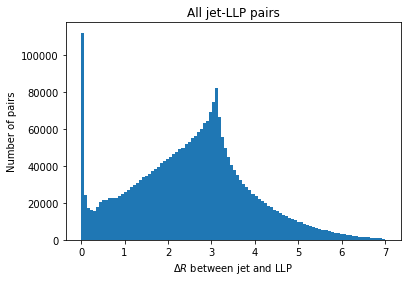

In [17]:
plt.hist(pair_dR.flatten(), 100, (0, 7))
plt.title('All jet-LLP pairs')
plt.xlabel('$\\Delta R$ between jet and LLP')
plt.ylabel('Number of pairs')
plt.show()

For fun, check how much faster this was than the usual nested loops:

In [18]:
%%time
for event_jet_p4, event_llp_p4 in zip(jet_p4, LLP_p4):
    for indiv_llp_p4 in event_llp_p4:
        for indiv_jet_p4 in event_jet_p4:
            deltaR(indiv_llp_p4, indiv_jet_p4)

CPU times: user 1min 7s, sys: 501 ms, total: 1min 8s
Wall time: 1min 7s


## LLP decay position query
I can almost get the CalRatio jets now. I need to get the LLP decay positions, so I'll do another query:

In [19]:
llp_decay_query = real_awkward_array_stream.Select('lambda e: (e.LLP_Lxy, e.LLP_Lz)')

In [20]:
%time LLP_Lxy, LLP_Lz = llp_decay_query.value()

CPU times: user 8.82 ms, sys: 15 ms, total: 23.9 ms
Wall time: 2.38 s


## CalRatio jet selection
Then make the final selection, using deltaR, eta, Lxy, and Lz:

In [21]:
import numpy as np
pair_jet_p4 = jet_p4[pair_jet_indices]
pair_llp_p4 = LLP_p4[pair_llp_indices]
pair_llp_lxy = LLP_Lxy[pair_llp_indices]
pair_llp_lz = LLP_Lz[pair_llp_indices]
pair_cr_jet_indices = np.bitwise_and(
    pair_dR < 0.2,
    np.bitwise_or(
        np.bitwise_and(abs(pair_jet_p4.eta()) < 1.4, np.bitwise_and(1800 < pair_llp_lxy, pair_llp_lxy < 4000)),
        np.bitwise_and(abs(pair_jet_p4.eta()) > 1.4, pair_llp_lz > 3500)
    )
)
cr_jets_indices = pair_jet_indices[pair_cr_jet_indices]
cr_jets = jet_p4[cr_jets_indices]
print('Total CR jets:', len(cr_jets.flatten()))

Total CR jets: 71068


# CR jet kinematics
Print out kinematics of the CR jets, to compare to overall jet distributions above:

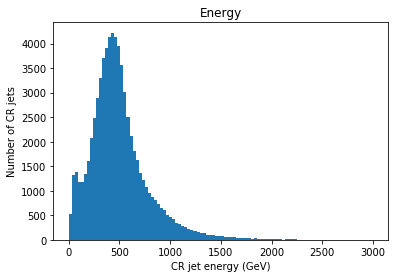

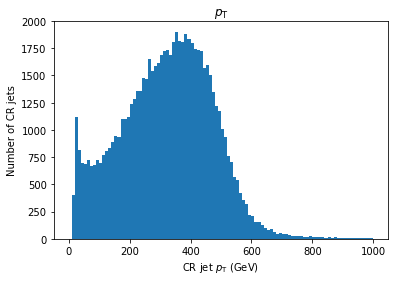

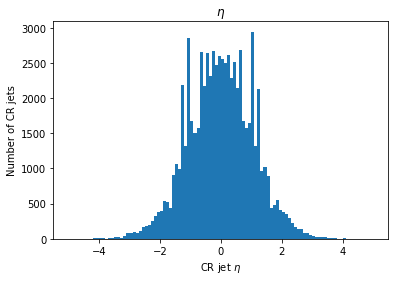

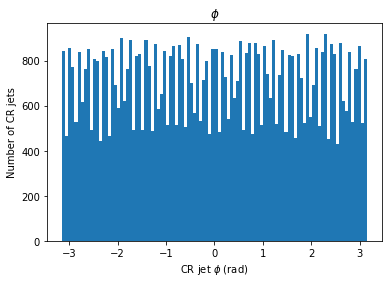

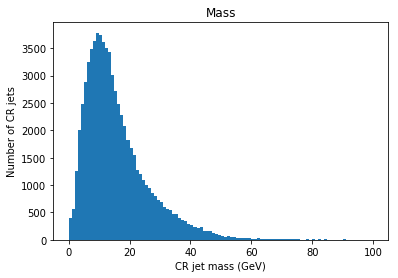

In [22]:
plt.hist(cr_jets.E().flatten(), 100, (0,3000))
plt.title('Energy')
plt.xlabel('CR jet energy (GeV)')
plt.ylabel('Number of CR jets')
plt.show()

plt.hist(cr_jets.pT().flatten(), 100, (0,1000))
plt.title('$p_\\mathrm{T}$')
plt.xlabel('CR jet $p_\\mathrm{T}$ (GeV)')
plt.ylabel('Number of CR jets')
plt.show()

plt.hist(cr_jets.eta().flatten(), 100, (-5,5))
plt.title('$\\eta$')
plt.xlabel('CR jet $\\eta$')
plt.ylabel('Number of CR jets')
plt.show()

plt.hist(cr_jets.phi().flatten(), 100, (-pi,pi))
plt.title('$\\phi$')
plt.xlabel('CR jet $\\phi$ (rad)')
plt.ylabel('Number of CR jets')
plt.show()

plt.hist(cr_jets.m().flatten(), 100, (0,100))
plt.title('Mass')
plt.xlabel('CR jet mass (GeV)')
plt.ylabel('Number of CR jets')
plt.show()

## Non-CR jets

Next, I want to get the leading and subleading jets of the non-CalRatio jets. These are candidates for a prompt decay of an LLP.

In [23]:
# First need to convert CR jet indices to a boolean mask
cr_jets_mask = jet_E.zeros_like().astype(bool)
cr_jets_mask[cr_jets_indices] = True
# Invert this to get non-CR jets
non_cr_jets_mask = ~cr_jets_mask
# We want to look at events with 1 CR jet and at least 2 other jets
events_with_1_cr = (cr_jets_indices.count() == 1)
events_with_lead_sublead = (non_cr_jets_mask.count_nonzero() >= 2)
events_with_cr_lead_sublead = (events_with_1_cr & events_with_lead_sublead)
# Combine the selections to pick out the leading/subleading jets we care about
lead_sublead_candidate_mask = (events_with_cr_lead_sublead & non_cr_jets_mask)
# Then get the actual four-momenta by using mask
# In principle, should sort jets by pT here, but the original ntuple is already sorted
lead_sublead_jets = jet_p4[lead_sublead_candidate_mask][:,:2]

In [24]:
# This step removes events that don't have 1 CR jet + 2 other jets. It's only needed to avoid matrix arithmetic errors.
selected_events_lead_sublead_jets = lead_sublead_jets[events_with_cr_lead_sublead]
selected_events_cr_jets = cr_jets[events_with_cr_lead_sublead].flatten()

Then add the leading and subleading jets to try to reconstruct the promptly decaying LLP:

In [25]:
lead_sublead_sum = selected_events_lead_sublead_jets[:,0] + selected_events_lead_sublead_jets[:,1]

## Leading + subleading jet sum kinematics

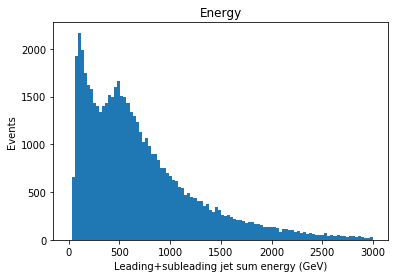

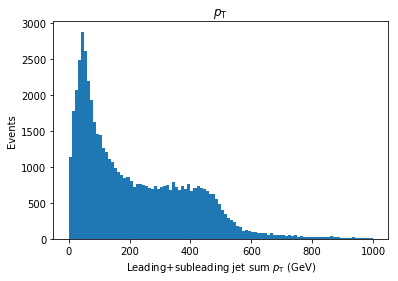

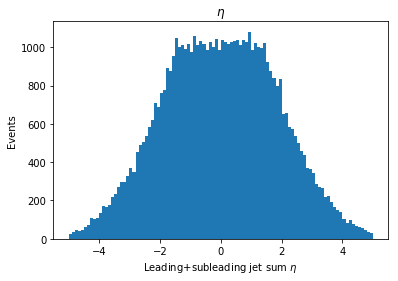

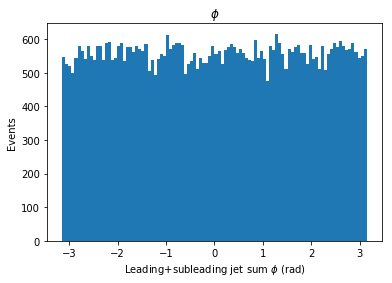

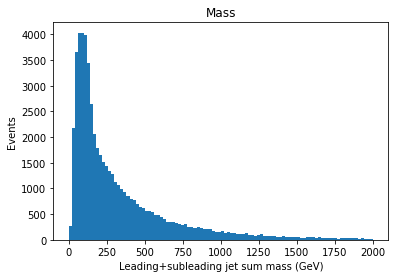

In [26]:
plt.hist(lead_sublead_sum.E().flatten(), 100, (0,3000))
plt.title('Energy')
plt.xlabel('Leading+subleading jet sum energy (GeV)')
plt.ylabel('Events')
plt.show()

plt.hist(lead_sublead_sum.pT().flatten(), 100, (0,1000))
plt.title('$p_\\mathrm{T}$')
plt.xlabel('Leading+subleading jet sum $p_\\mathrm{T}$ (GeV)')
plt.ylabel('Events')
plt.show()

plt.hist(lead_sublead_sum.eta().flatten(), 100, (-5,5))
plt.title('$\\eta$')
plt.xlabel('Leading+subleading jet sum $\\eta$')
plt.ylabel('Events')
plt.show()

plt.hist(lead_sublead_sum.phi().flatten(), 100, (-pi,pi))
plt.title('$\\phi$')
plt.xlabel('Leading+subleading jet sum $\\phi$ (rad)')
plt.ylabel('Events')
plt.show()

plt.hist(lead_sublead_sum.m().flatten(), 100, (0,2000))
plt.title('Mass')
plt.xlabel('Leading+subleading jet sum mass (GeV)')
plt.ylabel('Events')
plt.show()

## Potential variables for signal/background discrimination

Calculate a bunch of variables corresponding to differences between the CR jet and the leading + subleading jet sum, and between the leading and subleading jets. Note here that for differences in energy, pT, and mass, the quantity is unitless and represents the fractional difference from the average of the two inputs.

In [27]:
cr_lead_sublead_sum_dEta = deltaEta(selected_events_cr_jets, lead_sublead_sum)
cr_lead_sublead_sum_dPhi = abs(deltaPhi(selected_events_cr_jets, lead_sublead_sum))
cr_lead_sublead_sum_dE = (lead_sublead_sum.E() - selected_events_cr_jets.E()) / ((lead_sublead_sum.E() + selected_events_cr_jets.E()) / 2.0)
cr_lead_sublead_sum_dpT = (lead_sublead_sum.pT() - selected_events_cr_jets.pT()) / ((lead_sublead_sum.pT() + selected_events_cr_jets.pT()) / 2.0)
cr_lead_sublead_sum_dMass = (lead_sublead_sum.m() - selected_events_cr_jets.m()) / ((lead_sublead_sum.m() + selected_events_cr_jets.m()) / 2.0)

/home/mproffit/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:157: RuntimeWarning: invalid value encountered in sqrt


In [28]:
lead_sublead_dEta = deltaEta(selected_events_lead_sublead_jets[:,0], selected_events_lead_sublead_jets[:,1])
lead_sublead_dPhi = abs(deltaPhi(selected_events_lead_sublead_jets[:,0], selected_events_lead_sublead_jets[:,1]))
lead_sublead_dE = (selected_events_lead_sublead_jets[:,1].E() - selected_events_lead_sublead_jets[:,0].E()) / ((selected_events_lead_sublead_jets[:,1].E() + selected_events_lead_sublead_jets[:,0].E()) / 2.0)
lead_sublead_dpT = (selected_events_lead_sublead_jets[:,1].pT() - selected_events_lead_sublead_jets[:,0].pT()) / ((selected_events_lead_sublead_jets[:,1].pT() + selected_events_lead_sublead_jets[:,0].pT()) / 2.0)
lead_sublead_dMass = (selected_events_lead_sublead_jets[:,1].m() - selected_events_lead_sublead_jets[:,0].m()) / ((selected_events_lead_sublead_jets[:,1].m() + selected_events_lead_sublead_jets[:,0].m()) / 2.0)

/home/mproffit/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:157: RuntimeWarning: invalid value encountered in sqrt


Put these all together and plot variable pair distributions (using `pandas`):

In [29]:
all_vars = {'CR-LS dEta': cr_lead_sublead_sum_dEta,
            'CR-LS dPhi': cr_lead_sublead_sum_dPhi,
            'CR-LS dE': cr_lead_sublead_sum_dE,
            'CR-LS dpT': cr_lead_sublead_sum_dpT,
            'CR-LS dMass': cr_lead_sublead_sum_dMass,
            'L-S dEta': lead_sublead_dEta,
            'L-S dPhi': lead_sublead_dPhi,
            'L-S dE': lead_sublead_dE,
            'L-S dpT': lead_sublead_dpT,
            'L-S dMass': lead_sublead_dMass}

In [30]:
import pandas as pd

In [31]:
df = pd.DataFrame(all_vars)

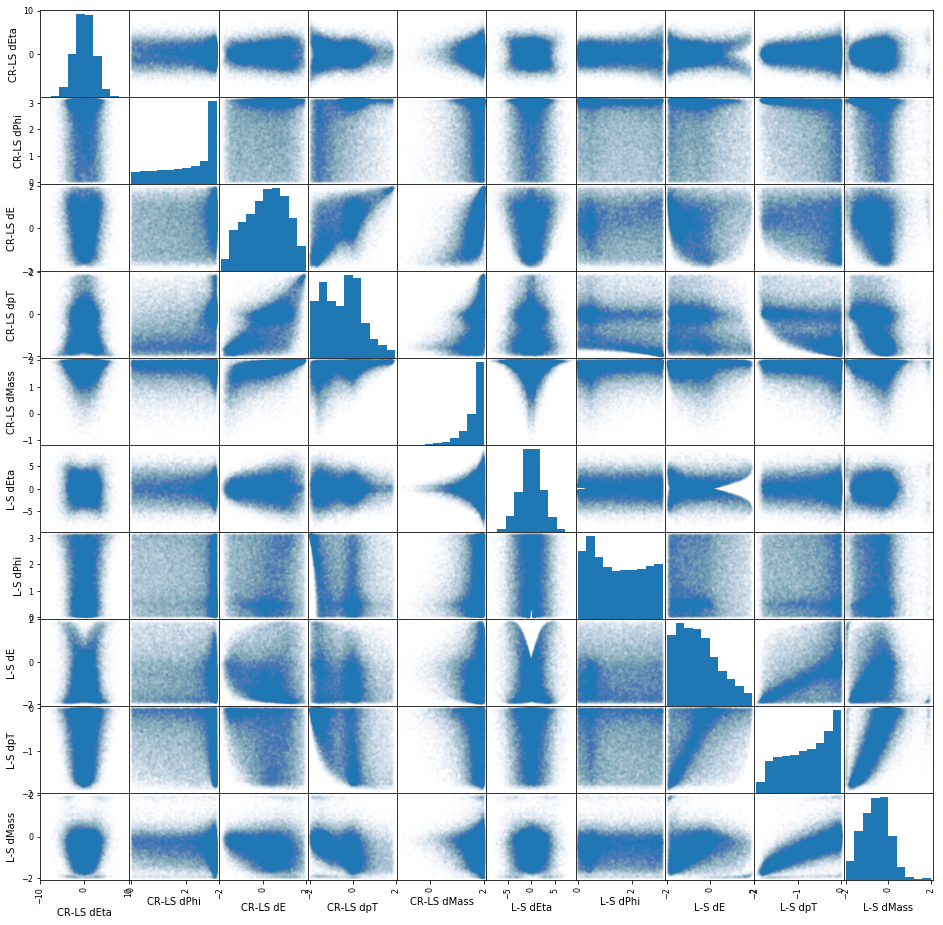

In [32]:
pd.plotting.scatter_matrix(df, alpha=0.01, figsize=(16, 16));